In [2]:
import ProcessDataset as prd
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import keras
import OneDimensionCNN
import numpy as np
import pandas as pd

In [4]:
window_size = 30
number_of_features = 2

original_dataset_filepath = "C:/Users/inhom/School/2024_1/2023연구재현/제일/101_1011_jeil.csv"
normal_dataset_filepath = "제일/chosenPatternJeil.csv"

original_df = prd.load_data(original_dataset_filepath, scale = True)
normal_df = prd.load_data(normal_dataset_filepath, scale = True)

original_X, original_Y = prd.create_dataset(original_df, shuffle = False, window_size = window_size, number_of_features = number_of_features)

train, valid, test = prd.train_test_split(normal_df, train_ratio = 0.6, valid_ratio = 0.75)
train_X, train_Y = prd.create_dataset(train, shuffle = True, window_size = window_size, number_of_features = number_of_features)
valid_X, valid_Y = prd.create_dataset(valid, shuffle = False, window_size = window_size, number_of_features = number_of_features)
test_X, test_Y = prd.create_dataset(test, shuffle = False, window_size = window_size, number_of_features = number_of_features)

In [3]:
model = OneDimensionCNN.get_model(window_size=window_size, numberOfFeatures= number_of_features)
OneDimensionCNN.print_summary(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            448       
                                                                 
 gru (GRU)                   (None, 30, 20)            5160      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 8,149
Trainable params: 8,149
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
history = OneDimensionCNN.train(model, train_X, train_Y, valid_X, valid_Y, set_epochs = 200)

Epoch 1/200
1635/1635 [==============================] - 11s 5ms/step - loss: 6.0678e-04 - mse: 6.0678e-04 - val_loss: 1.4028e-05 - val_mse: 1.4028e-05
Epoch 2/200
1635/1635 [==============================] - 8s 5ms/step - loss: 9.7509e-06 - mse: 9.7509e-06 - val_loss: 1.1042e-06 - val_mse: 1.1042e-06
Epoch 3/200
1635/1635 [==============================] - 8s 5ms/step - loss: 3.8890e-05 - mse: 3.8890e-05 - val_loss: 2.4171e-06 - val_mse: 2.4171e-06
Epoch 4/200
1635/1635 [==============================] - 8s 5ms/step - loss: 3.0417e-05 - mse: 3.0417e-05 - val_loss: 1.1512e-04 - val_mse: 1.1512e-04
Epoch 5/200
1635/1635 [==============================] - 8s 5ms/step - loss: 1.9108e-05 - mse: 1.9108e-05 - val_loss: 8.5587e-06 - val_mse: 8.5587e-06
Epoch 6/200
1635/1635 [==============================] - 8s 5ms/step - loss: 2.1406e-05 - mse: 2.1406e-05 - val_loss: 4.3441e-06 - val_mse: 4.3441e-06
Epoch 7/200
1635/1635 [==============================] - 8s 5ms/step - loss: 1.7455e-05 - mse

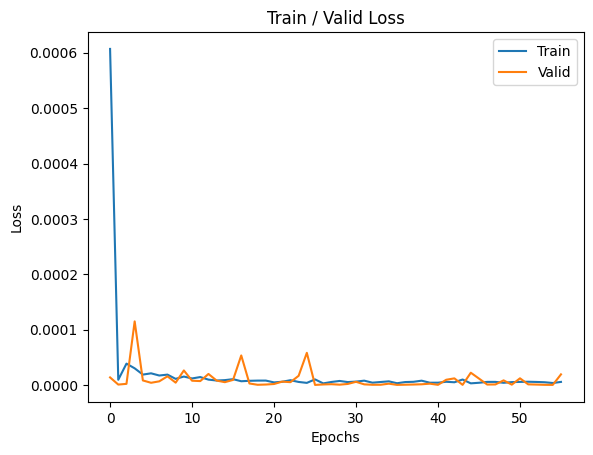

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train / Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [6]:
# model.save('model2.h5')

In [5]:
trainedModel = keras.models.load_model('model2.h5')

In [6]:
trainedModel.evaluate(test_X, test_Y)

364/364 [==============================] - 3s 2ms/step - loss: 5.5415e-07 - mse: 5.5415e-07


[5.541466521208349e-07, 5.541466521208349e-07]

In [84]:
def predict(model, data, idx, batch_size = 256):
    num_samples = min(idx, len(data))
    result = []
    batch_indices = np.arange(0, num_samples, batch_size)
    for start_idx in batch_indices:
        end_idx = min(start_idx + batch_size, num_samples)
        batch_data = np.array([data[i].reshape(1, data[i].shape[0], 2) for i in range(start_idx, end_idx)])
        batch_data = np.vstack(batch_data) 
        batch_predictions = model.predict(batch_data)
        result.extend(batch_predictions.flatten())

    result = np.array(result).reshape(-1, 1)

    nan_array = np.full((window_size - 1, 1), np.nan) 
    result = np.concatenate((nan_array, result), axis=0)

    return result

In [85]:
original_X_scale_restored = original_X.copy()

min_value = prd.load_data(original_dataset_filepath, scale = False)['attribute_1_value'].min()
max_value = prd.load_data(original_dataset_filepath, scale = False)['attribute_1_value'].max()

original_X_scale_restored[:,0,0] = original_X[:,0,0] * (max_value - min_value) + min_value

original_predict = predict(trainedModel, original_X, original_X.shape[0])

original_predict_scale_restored = original_predict * (max_value - min_value) + min_value
original_predict_scale_restored = original_predict_scale_restored.reshape(-1,)

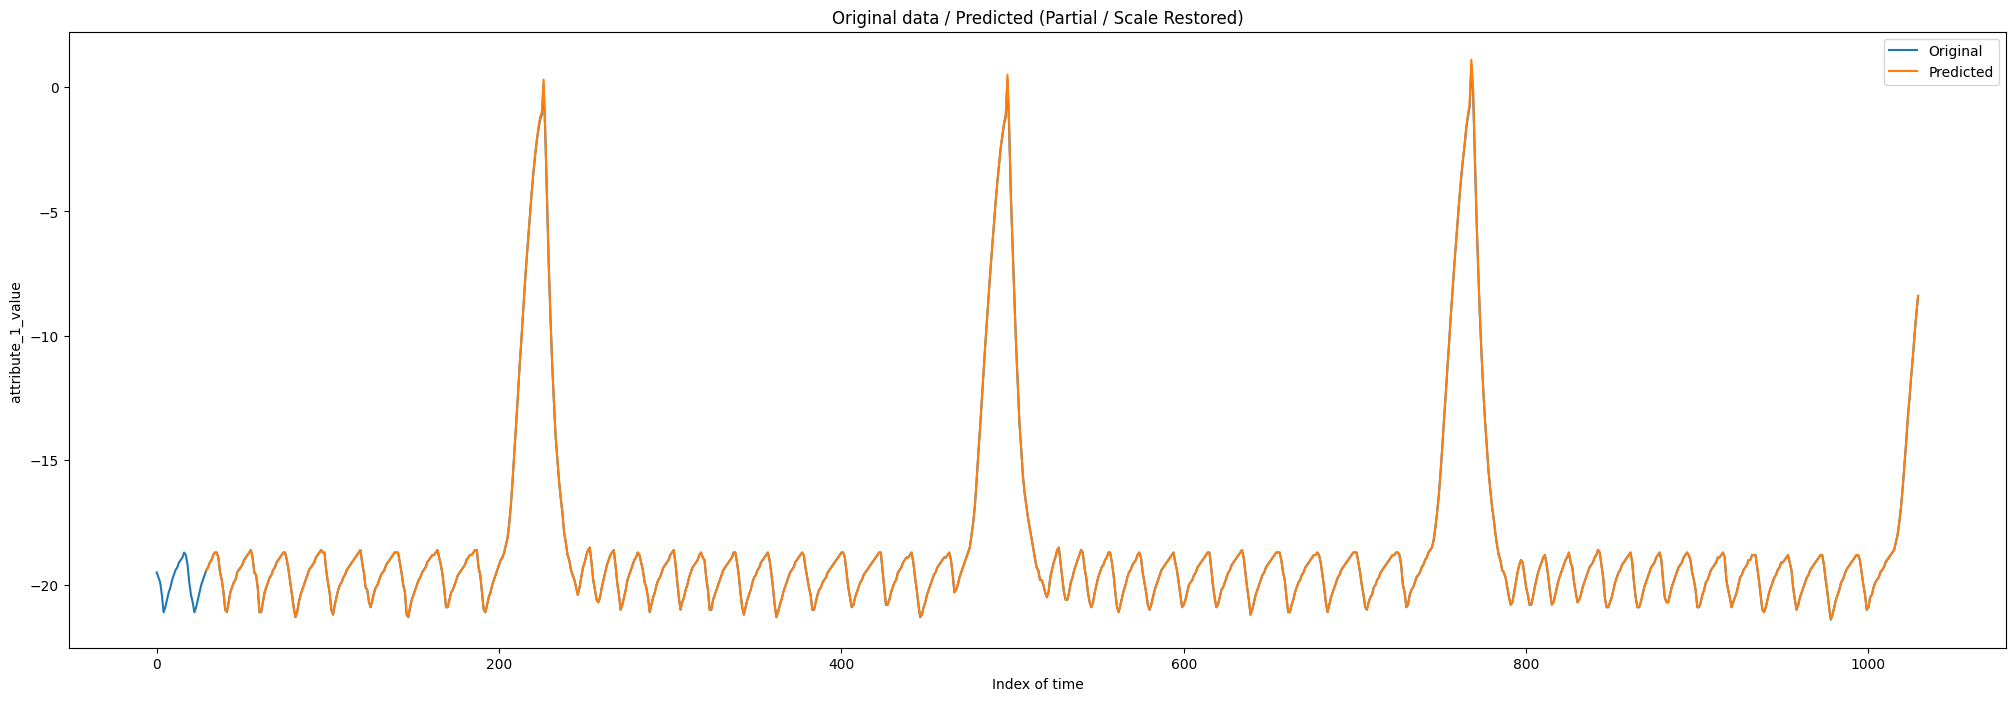

In [87]:
%matplotlib inline 
whereToSlice = 1030
plt.figure(figsize = (25,8))
plt.plot(np.arange(whereToSlice), original_X_scale_restored[:whereToSlice,0,0])
plt.plot(np.arange(whereToSlice), original_predict_scale_restored[:whereToSlice])
plt.title('Original data / Predicted (Partial / Scale Restored)')
plt.xlabel('Index of time')
plt.ylabel('attribute_1_value ')
plt.legend(['Original', 'Predicted'])
plt.show()

In [89]:
def calculateError(data, predicted) -> list:
    # MAEresult = np.abs(data[:,0] - predicted)
    MAEresult = np.abs(data - predicted)
    # MSEresult = np.square(data[:,0] - predicted)
    MSEresult = np.square(data - predicted)
    return MAEresult, MSEresult

In [91]:
OriginalMAE, OriginalMSE = calculateError(original_X_scale_restored[:,0,0], original_predict_scale_restored[: -window_size+1])

In [92]:
print(original_X_scale_restored[30,0,0]) 
print(original_predict_scale_restored[30])
print(original_X_scale_restored[30,0,0] - original_predict_scale_restored[30])

-19.3
-19.301321732252834
0.0013217322528333852


In [74]:
OriginalMAE[30]

0.10051361918449331

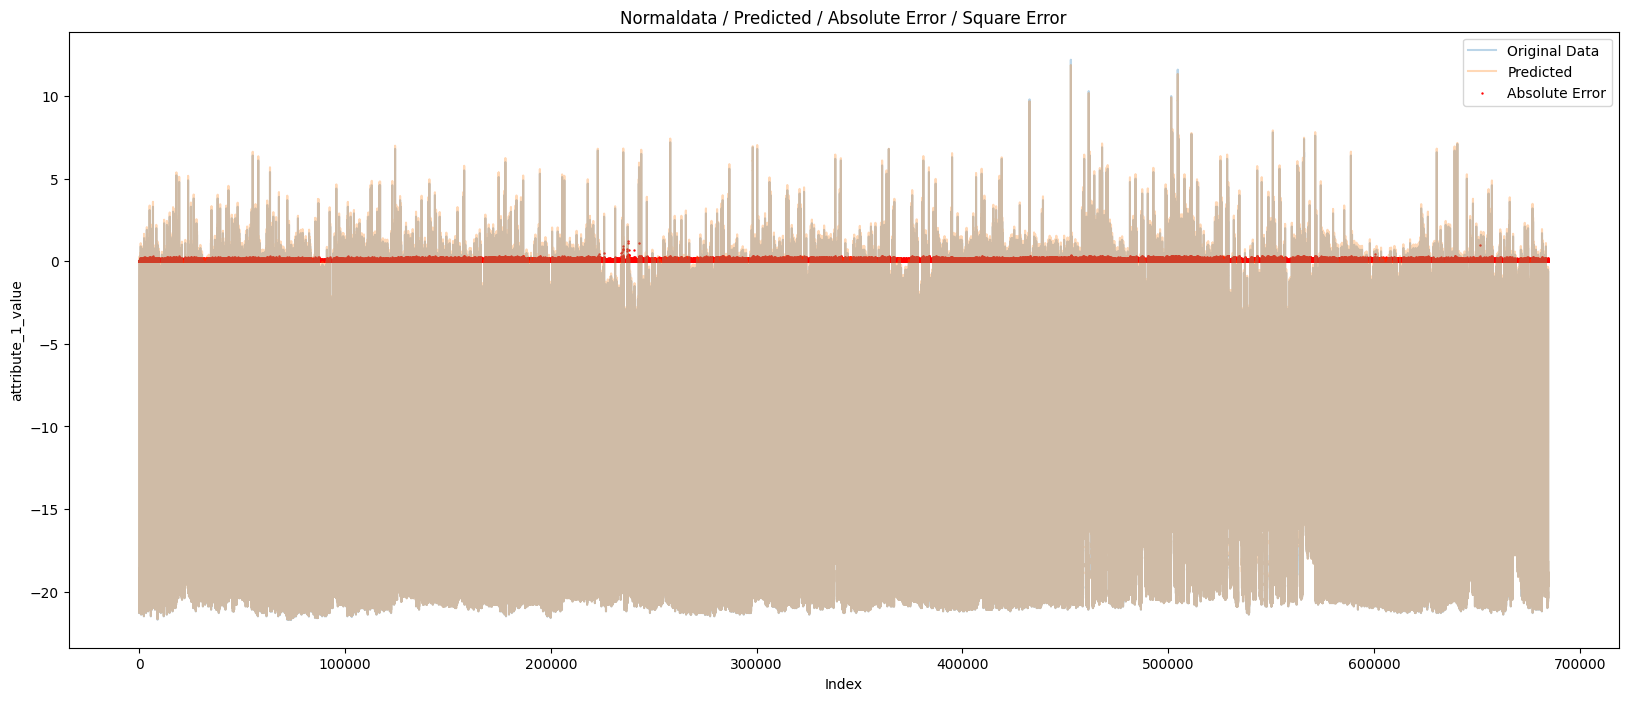

In [98]:
%matplotlib inline

plt.figure(figsize = (20,8))
plt.plot(np.arange(OriginalMAE.shape[0]), original_X_scale_restored[:,0,0], label = 'Original Data', alpha = 0.3)
plt.plot(np.arange(OriginalMAE.shape[0]), original_predict_scale_restored[:-window_size+1], label = 'Predicted', alpha = 0.3)
# plt.plot(np.arange(OriginalMAE.shape[0]), OriginalMAE, label = 'Absolute Error', linestyle = '--', color = 'red')
# plt.plot(np.arange(OriginalMAE.shape[0]), OriginalMSE, label = 'Square Error', linestyle = '-.')
plt.scatter(np.arange(OriginalMAE.shape[0]), OriginalMAE, label = 'Absolute Error', s = 0.5, color = 'red')
# plt.scatter(np.arange(OriginalMSE.shape[0]), OriginalMSE, label = 'Square Error', s = 2, color = 'green')
plt.xlabel('Index')
plt.ylabel('attribute_1_value')
plt.title('Normaldata / Predicted / Absolute Error / Square Error')
plt.legend()
plt.show()

In [81]:
cnt = 0
for i in range(len(OriginalMSE)):
    if OriginalMSE[i] >= 15:
        cnt = cnt + 1;

print(cnt)

380


In [83]:
import numpy as np

# 가정: error_values는 계산된 제곱 에러의 배열
window_size = 30
threshold = 3
mean = np.convolve(OriginalMSE, np.ones(window_size)/window_size, mode='valid')
std = np.sqrt(np.convolve(np.square(OriginalMSE - mean), np.ones(window_size)/window_size, mode='valid'))

outliers = np.sum(np.abs(OriginalMSE[window_size-1:] - mean) > threshold * std)



ValueError: operands could not be broadcast together with shapes (684552,) (684523,) 